In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# get training and validation(=testing) data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/comp473ProjectData/TrainSet1', 
    image_size = (48,48), # our original dataset is 48 pixels by 48 pixels
    batch_size = 12 # pick 12 images and trin until all dataset is used <= repeat this for each epoche
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/comp473ProjectData/TestSet1', 
    image_size = (48,48), 
    batch_size = 12
)


Found 693 files belonging to 7 classes.
Found 288 files belonging to 7 classes.


In [3]:
train_ds # form shape=(None, 48, 48, 3) <- 3 represent that the photo is treated as colored. one pixel will have [R G B] values between 0~255

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

tf.Tensor(
[[[[ 42.  42.  42.]
   [ 44.  44.  44.]
   [ 59.  59.  59.]
   ...
   [ 49.  49.  49.]
   [ 49.  49.  49.]
   [ 51.  51.  51.]]

  [[ 39.  39.  39.]
   [ 42.  42.  42.]
   [ 45.  45.  45.]
   ...
   [ 40.  40.  40.]
   [ 49.  49.  49.]
   [ 47.  47.  47.]]

  [[ 35.  35.  35.]
   [ 32.  32.  32.]
   [ 34.  34.  34.]
   ...
   [ 38.  38.  38.]
   [ 43.  43.  43.]
   [ 44.  44.  44.]]

  ...

  [[ 80.  80.  80.]
   [ 87.  87.  87.]
   [ 83.  83.  83.]
   ...
   [237. 237. 237.]
   [189. 189. 189.]
   [ 81.  81.  81.]]

  [[ 84.  84.  84.]
   [ 87.  87.  87.]
   [ 81.  81.  81.]
   ...
   [252. 252. 252.]
   [159. 159. 159.]
   [ 73.  73.  73.]]

  [[ 84.  84.  84.]
   [ 84.  84.  84.]
   [ 80.  80.  80.]
   ...
   [248. 248. 248.]
   [149. 149. 149.]
   [ 68.  68.  68.]]]


 [[[ 20.  20.  20.]
   [  4.   4.   4.]
   [ 10.  10.  10.]
   ...
   [ 81.  81.  81.]
   [ 93.  93.  93.]
   [ 96.  96.  96.]]

  [[  6.   6.   6.]
   [  7.   7.   7.]
   [  7.   7.   7.]
   ...
   [ 42.  

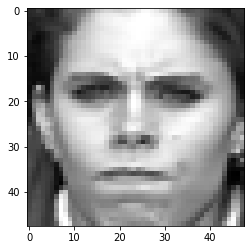

In [4]:
# try to output one of our image

for i, answer in train_ds.take(1): #take(1): takes first batch. 

  print(i) # outputs 12(=batch size) photos as numpy array ,shape=(12, 48, 48, 3) means 12 photos, each photo size(48,48 pixels), 3=color= each cell represented as [R G B]
  print(answer) # outputs correct answer for current batch [ 5 2 6 ...] <- first photo in this batch is in class 5, second photo in this patch is in class 2.. 

plt.imshow(i[0].numpy().astype('uint8')) # output the first photo using matplotlib
plt.show()


In [5]:
# preprocess colored data
# since the numbers are between 0~255 for each R, G, and B, it is slower to train and calculate weights.
# it is better to divide each number with 255, so each value resides within 0~1

def processColoredData(i, answer):
  i=tf.cast(i/255.0, tf.float32) # devide i by 255, resulting data type should be float
  return i, answer

train_ds = train_ds.map(processColoredData)
val_ds = val_ds.map(processColoredData)

In [6]:
# try to output our image if 'processColoredData' function is working well.
for i, answer in train_ds.take(1): #take first batch 
  print(i) # now you can see that the values are compressed btw 0~1


tf.Tensor(
[[[[0.4745098  0.4745098  0.4745098 ]
   [0.4117647  0.4117647  0.4117647 ]
   [0.34509805 0.34509805 0.34509805]
   ...
   [0.5764706  0.5764706  0.5764706 ]
   [0.56078434 0.56078434 0.56078434]
   [0.57254905 0.57254905 0.57254905]]

  [[0.41568628 0.41568628 0.41568628]
   [0.37254903 0.37254903 0.37254903]
   [0.34901962 0.34901962 0.34901962]
   ...
   [0.60784316 0.60784316 0.60784316]
   [0.6156863  0.6156863  0.6156863 ]
   [0.5921569  0.5921569  0.5921569 ]]

  [[0.37254903 0.37254903 0.37254903]
   [0.29411766 0.29411766 0.29411766]
   [0.3254902  0.3254902  0.3254902 ]
   ...
   [0.654902   0.654902   0.654902  ]
   [0.6392157  0.6392157  0.6392157 ]
   [0.5921569  0.5921569  0.5921569 ]]

  ...

  [[0.3882353  0.3882353  0.3882353 ]
   [0.39607844 0.39607844 0.39607844]
   [0.39607844 0.39607844 0.39607844]
   ...
   [0.45882353 0.45882353 0.45882353]
   [0.4627451  0.4627451  0.4627451 ]
   [0.49411765 0.49411765 0.49411765]]

  [[0.3882353  0.3882353  0.388235

In [7]:
# making model
model = tf.keras.Sequential([
    

    # .conv2D : with feature extraction we can expect higher accuracy               
    # 1st param: make 32 different features. use such features to train better model. 
    # 2nd param: kernel size is 3x3
    # 3rd param: when using convolutional layer, (=when kernel is applied to each photo) the size of photo will shrink. we will put some padding here to retain 48*48 size even after feature extraction.
    # 4th param: activation function. relu compress number to 0~1. There's no negative number in photo so it is good to use relu.
    # 5th param: input_shape : shate of one photo data
    tf.keras.layers.Conv2D( 32, (3,3), padding='same' , activation='relu', input_shape=(48,48,3)), 
    
    
    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    tf.keras.layers.MaxPooling2D((2,2)),

    # helps prevent overfittng ( randomly sets input units to 0 with frequency of rate)
    tf.keras.layers.Dropout(0.2), 

    # It is okay to repreat [Conv-Pooling] several times
    # we will repeat [Conv-Pooling] two more times to increase learning effect
    tf.keras.layers.Conv2D( 64, (3,3), padding='same' , activation='relu'), 
    tf.keras.layers.MaxPooling2D((2,2)), 
        
    tf.keras.layers.Conv2D( 128, (3,3), padding='same' , activation='relu'), 
    tf.keras.layers.MaxPooling2D((2,2)), 


    # Flatten-Dense
    tf.keras.layers.Flatten(), 
    ## 1st layer
    tf.keras.layers.Dense(64, activation="relu"), # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dropout(0.2), # helps prevent overfittng
    ## second layer. we must have 7 final nodes because we have 7 classes.
    tf.keras.layers.Dense(7, activation="softmax") # softmax: compress resulting number between 0~1, used in category problems. If you add up the probability of each class we get 1. 
])





# prints summary of our model. 
model.summary()


# compile and fit our model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam" , metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       7